In [1]:
import torch
import sklearn
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPool2D, Dropout,Flatten, Conv1D, MaxPool1D, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split

import time
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import math
import matplotlib.pyplot as plt
import json
import math


In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i]) 
        dataY.append(d_y[i + fore_cast,:])
    
    return np.array(dataX), np.array(dataY)

In [5]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\SD\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [6]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']
#file_name = ['TH_4_I.xls', 'TH_2_I.xls', 'TH_3_I.xls']
file_name = ['SD_1_I_r.xls', 'SD_4_I_r.xls', 'SD_2_I_r.xls', 'SD_3_I_r.xls', 'SD_5_I_r.xls']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217324 entries, 0 to 217323
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      217324 non-null  float64
 1   l_ph_ank      217324 non-null  float64
 2   l_ph_fo       217324 non-null  float64
 3   r_ph_hip      217324 non-null  float64
 4   r_ph_ank      217324 non-null  float64
 5   r_ph_fo       217324 non-null  float64
 6   n_lgrf        217324 non-null  float64
 7   n_r_grf       217324 non-null  float64
 8   n_lcop        217324 non-null  float64
 9   n_rcop        217324 non-null  float64
 10  perc_new      217324 non-null  float64
 11  st_sw_phase   217324 non-null  int64  
 12  strike_frame  217324 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 21.6 MB


In [8]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table
        

l_ph_hip  l_ph_ank   l_ph_fo  r_ph_hip  r_ph_ank   r_ph_fo    n_lgrf  \
0       0.666033  0.734517  0.913452  0.970620  0.851290  0.727901  0.806949   
1       0.650675  0.734793  0.863640  0.968539  0.839093  0.726313  0.802553   
2       0.629181  0.734931  0.832964  0.966254  0.829650  0.724480  0.796333   
3       0.598268  0.734953  0.813427  0.963737  0.822212  0.722370  0.788140   
4       0.554275  0.734873  0.800185  0.960966  0.816268  0.719932  0.777857   
...          ...       ...       ...       ...       ...       ...       ...   
216121  0.689740  0.738954  0.027675  0.989151  0.086381  0.754645  0.885541   
216122  0.683541  0.739095  0.949423  0.987145  0.045776  0.752612  0.890962   
216123  0.676084  0.739102  0.886597  0.985371  0.000023  0.750734  0.894725   
216124  0.666912  0.739000  0.846860  0.983775  0.955932  0.748939  0.896586   
216125  0.655355  0.738808  0.822223  0.982298  0.918855  0.747177  0.896328   

         n_r_grf    n_lcop        n_rcop   perc_new  st_sw_phase  strike_frame  
0       0.051172  0.000000  9.057113e-04   0.000000            1             1  
1       0.067357  0.000000  1.167284e-03   0.456621            1             2  
2       0.085088  0.000000  1.461412e-03   0.913242            1             3  
3       0.103916  0.000000  1.788757e-03   1.369863            1             4  
4       0.123481  0.000000  2.152239e-03   1.826484            1             5  
...          ...       ...           ...        ...          ...           ...  
216121  0.000000  0.118095  9.989409e-07  97.222222            0           211  
216122  0.000000  0.119433  2.808689e-04  97.685185            0           212  
216123  0.000000  0.120731  6.225959e-04  98.148148            0           213  
216124  0.010381  0.121968  1.032033e-03  98.611111            0           214  
216125  0.020762  0.123127  1.514632e-03  99.074074            0           215  

[216126 rows x 13 columns]

In [9]:
source_table = source_table.drop(["n_lgrf","n_r_grf", "l_ph_ank", "r_ph_ank", "l_ph_fo", "r_ph_fo", "l_ph_hip", "n_lcop"], axis = 1)
source_table

r_ph_hip        n_rcop   perc_new  st_sw_phase  strike_frame
0       0.970620  9.057113e-04   0.000000            1             1
1       0.968539  1.167284e-03   0.456621            1             2
2       0.966254  1.461412e-03   0.913242            1             3
3       0.963737  1.788757e-03   1.369863            1             4
4       0.960966  2.152239e-03   1.826484            1             5
...          ...           ...        ...          ...           ...
216121  0.989151  9.989409e-07  97.222222            0           211
216122  0.987145  2.808689e-04  97.685185            0           212
216123  0.985371  6.225959e-04  98.148148            0           213
216124  0.983775  1.032033e-03  98.611111            0           214
216125  0.982298  1.514632e-03  99.074074            0           215

[216126 rows x 5 columns]

In [10]:
source_table.info()
source_table.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216126 entries, 0 to 216125
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   r_ph_hip      216126 non-null  float64
 1   n_rcop        216126 non-null  float64
 2   perc_new      216126 non-null  float64
 3   st_sw_phase   216126 non-null  int64  
 4   strike_frame  216126 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 8.2 MB


count        mean        std       min        25%  \
r_ph_hip      216126.0    0.556441   0.314761  0.000008   0.232720   
n_rcop        216126.0    0.029488   0.030466 -0.003407   0.000037   
perc_new      216126.0   49.541275  28.731310  0.000000  24.651163   
st_sw_phase   216126.0    0.505201   0.499974  0.000000   0.000000   
strike_frame  216126.0  108.610251  63.500221  1.000000  54.000000   

                     50%         75%         max  
r_ph_hip        0.718793    0.806019    1.000000  
n_rcop          0.022591    0.054261    0.103847  
perc_new       49.523810   74.418605   99.557522  
st_sw_phase     1.000000    1.000000    1.000000  
strike_frame  108.000000  161.000000  287.000000

In [11]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [12]:
#x = x.drop(['r_ph_foot'], axis=1)
#x = x.drop(['r_ph_hip'], axis=1)

In [13]:
data_y = y.values.reshape(-1,2)

In [14]:
type(data_y)

numpy.ndarray

In [15]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25, 
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [16]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

(162083, 10, 4)
(162083, 2)
(54021, 10, 4)
(54021, 2)


In [17]:
print(train_x.shape)
print(validation_x.shape)

(162083, 10, 4)
(54021, 10, 4)


In [18]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        curLR = optimizer.lr
        return curLR
    return lr

In [19]:
epochs = 30
batch_size = 64                                                                
learning_rate = 1e-2

# learning rate scheduler
use_lr_scheduler = True
lr_factor = 0.5
lr_patience = 8
lr_threshold = 0.01
lr_min_rate = 1e-6


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Sequential()
model.add((Conv1D(50, kernel_size=2, strides=1,input_shape=(look_back,train_x.shape[2]), activation='relu')))
model.add(MaxPool1D(pool_size=2, strides=1))
model.add(Dropout(0.1))
#model.add(TimeDistributed(Flatten()))
model.add(LSTM(30, return_sequences = True))
model.add(LSTM(10))
model.add(Flatten())
model.add(Dense(2))

#model.build((2,10,10))
#model.build()
print(model.summary())

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', get_lr_metric(optimizer), 'mae','mse'])
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=monitor,verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 50)             450       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 50)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 50)             0         
                                                                 
 lstm (LSTM)                 (None, 8, 30)             9720      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1640      
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                        

In [20]:
# make predictions
trainPredict = model.predict(train_x)
testPredict = model.predict(validation_x)

1689/1689 [==============================] - 6s 3ms/step


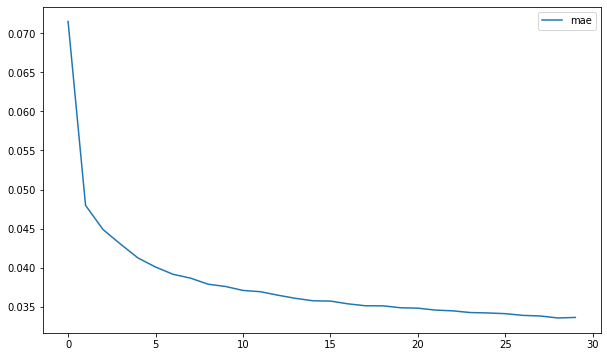

In [21]:

# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
#plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show() 

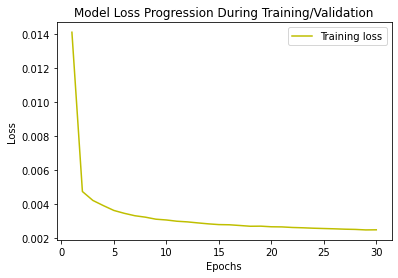

In [22]:
loss= history.history['loss']

epochs=range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')

plt.title('Model Loss Progression During Training/Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

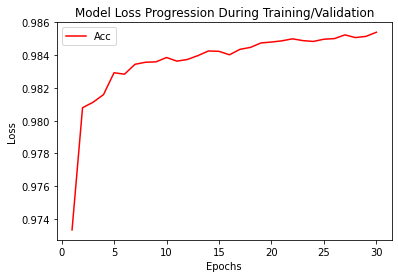

In [23]:

accuracy=history.history['accuracy']
epochs=range(1,len(loss)+1)
plt.plot(epochs,accuracy, 'r', label='Acc')
plt.title('Model Loss Progression During Training/Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [41]:
validation_x[0].shape

(10, 4)

In [42]:
validation_x.shape
test_data = np.reshape(validation_x[0],(1, validation_x[0].shape[0], validation_x[0].shape[1]))

In [43]:
v = X_test[11:]
v.shape

(54021, 4)

In [44]:
test = model.predict(test_data)
test

1/1 [==============================] - 0s 20ms/step


array([[-0.18398468, -0.98101497]], dtype=float32)

In [45]:
trainPredict.shape

(162083, 2)

In [46]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


In [47]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  
  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) : 
    pred[iter] = pred[iter] - 100  
    if abs(pred[iter]) >= 5:
      pred[iter] = 0 
  

  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
    pred[iter] = 100 - pred[iter]
    if abs(pred[iter]) >= 5:
        pred[iter] = 100

  

  

  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [48]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


In [49]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [50]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

35803
54021
Precision  1 :  66.2760778215879
48914
54021
Precision  2 :  90.54626904352011
52453
54021
Precision  3 :  97.09742507543363
53490
54021
Precision  4 :  99.0170489254179
53966
54021
Precision  5 :  99.89818774180411


In [51]:
# linspace
#rv = multivariate_normal ([0,0],[1,.5],[.5,1])
# Z = rv,pdf(pos)
# contour(x,y,z)

In [52]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)

Predicting Percentage RMSE:  1.2149187729706004


In [53]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

54021
54021
1.2149187729706092


Text(0, 0.5, 'Percentage (%)')

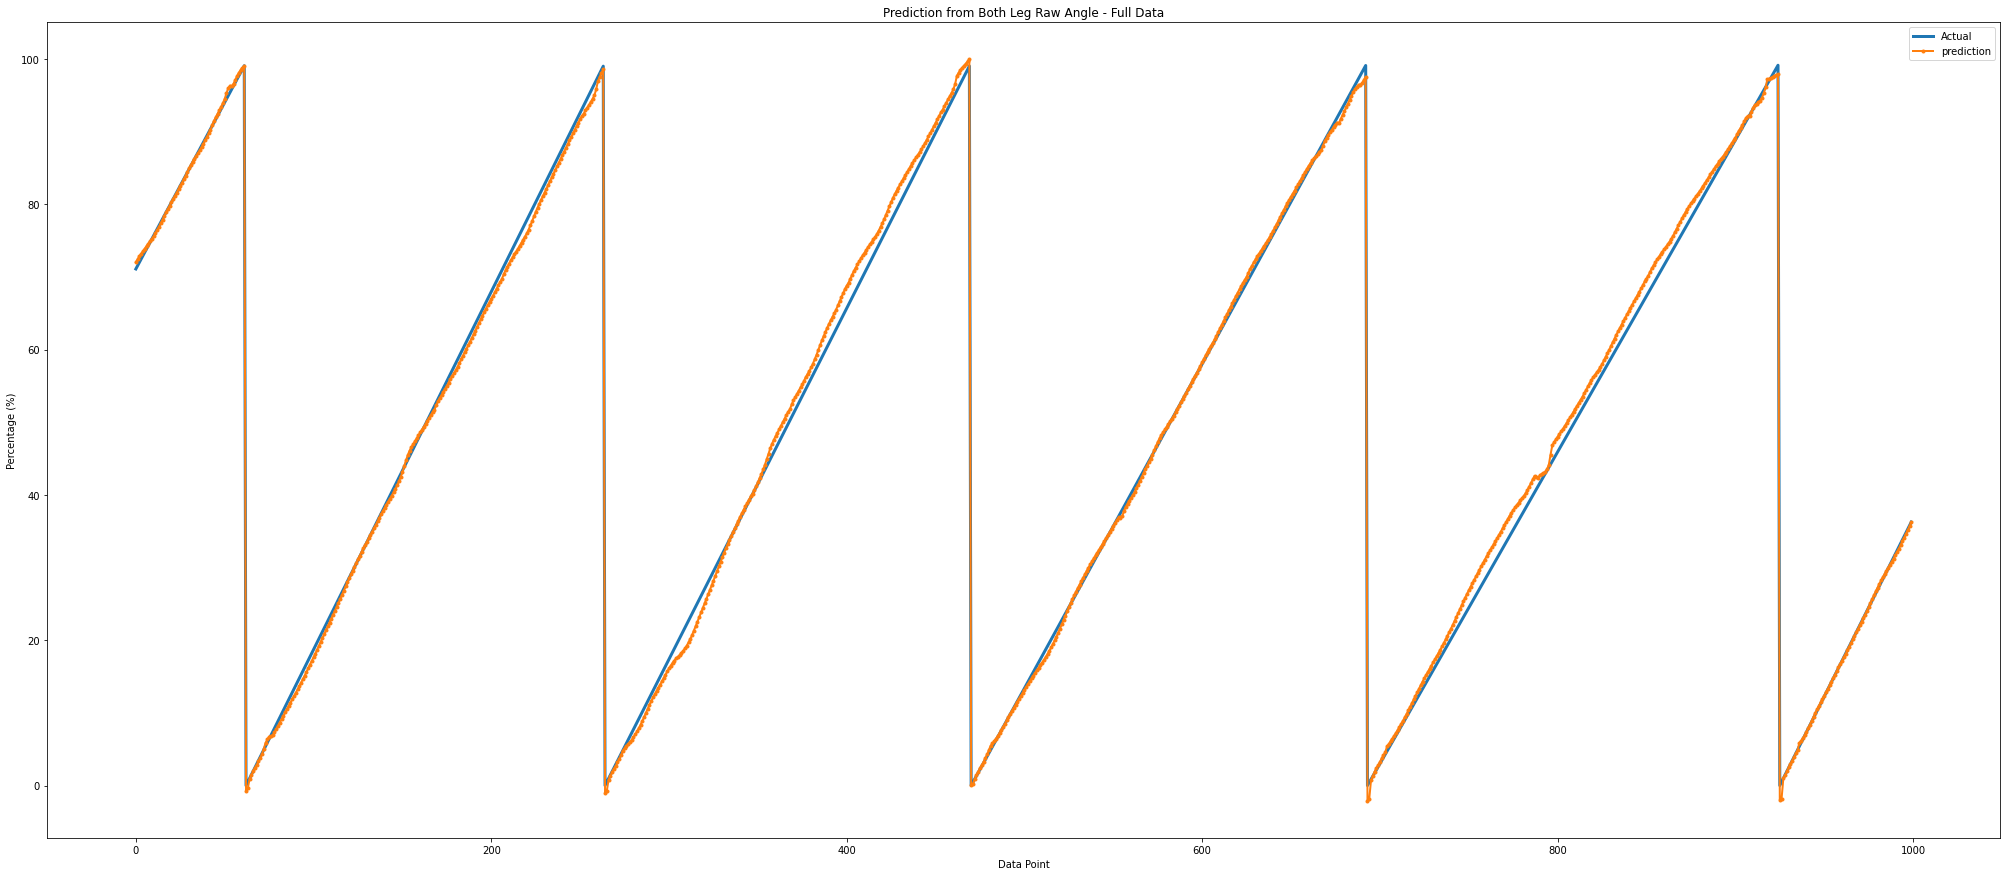

In [54]:
#plt.plot(Y[52272:52470],LShank[52272:52470],'--',label='Actual')
#plt.plot(pred,LShank,'--',label='prediction')
fig=plt.figure(figsize=(35,15))

plt.plot(actual[0:1000],'-',label='Actual', linewidth = 3)
plt.plot(pred[0:1000],'.-',label='prediction', linewidth = 2)



#plt.plot(actual[350:556],Rfoot[350:556],'.',label='Actual')
#plt.plot(pred[350:556],Rfoot[350:556],'.',label='prediction')

plt.legend()
plt.title('Prediction from Both Leg Raw Angle - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

Text(0.5, 1.0, 'Actual vs Prediction')

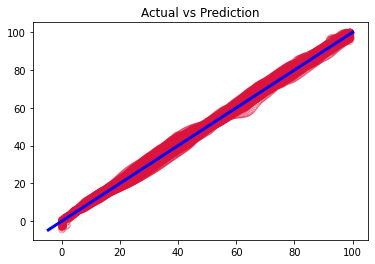

In [55]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

In [56]:
#predict = np.zeros((len(test_new),1))

#for iter in range(len(test_new)):
#  x = test_new[iter][0]
#  y = test_new[iter][1]
#  predict[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


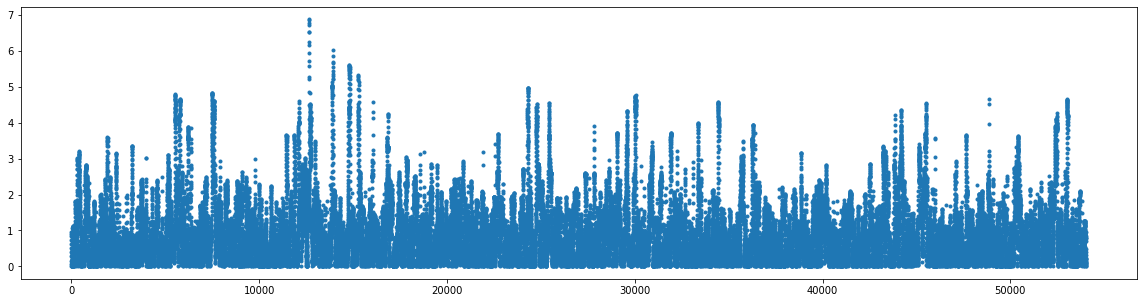

In [59]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')


In [60]:
data_dif = pd.DataFrame(pred)
print(data_dif.to_string())

                0
0       72.049401
1       72.469068
2       72.858959
3       73.220220
4       73.557197
5       73.913659
6       74.258167
7       74.591377
8       74.919346
9       75.250557
10      75.606217
11      76.006375
12      76.442198
13      76.904230
14      77.392276
15      77.895654
16      78.409719
17      78.913551
18      79.377273
19      79.832470
20      80.286940
21      80.738722
22      81.184513
23      81.620955
24      82.068475
25      82.529402
26      82.996249
27      83.474013
28      83.965703
29      84.464241
30      84.957453
31      85.433080
32      85.882157
33      86.298980
34      86.681715
35      87.038962
36      87.438456
37      87.881353
38      88.346623
39      88.820759
40      89.298606
41      89.776952
42      90.263873
43      90.902685
44      91.495957
45      92.000955
46      92.468491
47      92.949190
48      93.444848
49      93.939767
50      94.520684
51      95.300867
52      96.018260
53      96.337094
54      96

In [61]:
act_dif = pd.DataFrame(actual)
print(act_dif.to_string())

               0
0      71.100917
1      71.559633
2      72.018349
3      72.477064
4      72.935780
5      73.394495
6      73.853211
7      74.311927
8      74.770642
9      75.229358
10     75.688073
11     76.146789
12     76.605505
13     77.064220
14     77.522936
15     77.981651
16     78.440367
17     78.899083
18     79.357798
19     79.816514
20     80.275229
21     80.733945
22     81.192661
23     81.651376
24     82.110092
25     82.568807
26     83.027523
27     83.486239
28     83.944954
29     84.403670
30     84.862385
31     85.321101
32     85.779817
33     86.238532
34     86.697248
35     87.155963
36     87.614679
37     88.073394
38     88.532110
39     88.990826
40     89.449541
41     89.908257
42     90.366972
43     90.825688
44     91.284404
45     91.743119
46     92.201835
47     92.660550
48     93.119266
49     93.577982
50     94.036697
51     94.495413
52     94.954128
53     95.412844
54     95.871560
55     96.330275
56     96.788991
57     97.2477

In [62]:
for i in range(len(pred)):
    if (abs(actual[i]-pred[i]) > 50):
        print(i)

In [63]:
strike = pd.DataFrame(x_test[:,-1])
print(strike.to_string())

           0
0      156.0
1      157.0
2      158.0
3      159.0
4      160.0
5      161.0
6      162.0
7      163.0
8      164.0
9      165.0
10     166.0
11     167.0
12     168.0
13     169.0
14     170.0
15     171.0
16     172.0
17     173.0
18     174.0
19     175.0
20     176.0
21     177.0
22     178.0
23     179.0
24     180.0
25     181.0
26     182.0
27     183.0
28     184.0
29     185.0
30     186.0
31     187.0
32     188.0
33     189.0
34     190.0
35     191.0
36     192.0
37     193.0
38     194.0
39     195.0
40     196.0
41     197.0
42     198.0
43     199.0
44     200.0
45     201.0
46     202.0
47     203.0
48     204.0
49     205.0
50     206.0
51     207.0
52     208.0
53     209.0
54     210.0
55     211.0
56     212.0
57     213.0
58     214.0
59     215.0
60     216.0
61     217.0
62       1.0
63       2.0
64       3.0
65       4.0
66       5.0
67       6.0
68       7.0
69       8.0
70       9.0
71      10.0
72      11.0
73      12.0
74      13.0
75      14.0

In [64]:
x_test[18604][:]

array([7.85686000e-01, 4.64827561e-02, 0.00000000e+00, 5.60000000e+01])

In [65]:
print('Predict: ', pred[18604])
print('Actual: ', actual[18604])

Predict:  [25.36136979]
Actual:  [25.46296296]


In [66]:
dif[18604]

array([0.10159317])